In [1]:
#import packages
import sqlite3
import pandas as pd
from utils import preprocess_data, get_matches

In [5]:
# get data from here:
# https://gitlab.opencode.de/robert-koch-institut/zentrum-fuer-krebsregisterdaten/cancerdata-generator/-/tree/main/assets?ref_type=heads
#sqlite_con = sqlite3.connect("C:/Python/spacy_matching/data/fake_clin_data.db")
#free_text_data = pd.read_sql_query(
#    "SELECT distinct Bezeichnung FROM Substanz", sqlite_con
#)
#sqlite_con.close()

free_text_data = pd.read_csv("../local/Test_Daten.csv", sep= ";")

col_with_substances_ZfKD_fake_data = free_text_data["Bezeichnung"]



# get valid substance from reference list provided by ZfKD 
URL_LINK = "https://gitlab.opencode.de/robert-koch-institut/zentrum-fuer-krebsregisterdaten/cancerdata-references/-/raw/main/data/v2/Klassifikationen/substanz.csv?ref_type=heads"
reference_list = pd.read_csv(URL_LINK, sep=";")
col_with_ref_substances_ZfKD = reference_list["substanz"]

In [3]:
# define function to extract valid substances
def create_substance_service_var(
    col_with_substances: pd.Series,
    col_with_ref_substances: pd.Series,
    threshold: float = 0.85,
    max_per_match_id: int = 2,
    only_first_match: bool = False,
) -> pd.DataFrame:
    """
    This is the pipeline for creating the service variable
    for substances using ZfKD data.
    The functions are described in detail in utils.py.
    In short, the functions takes a pandasDataFrame column
    as an input and preprocesses its entries first.
    This results in a pandasDataFrame with the original
    input in one column and the preprocessed text in another one.
    The fuzzy matching relies on FuzzyMatcher from spaczz.
    It uses the preprocessed input and a reference list that
    the uses needs to provide. The reference list must be 
    a pandasDataFrame column (pd.Series) with substance names.
    The output is a pandasDataFrame with the original input,
    the preprocessed text and all possible matches with similary score.
    Use parameters to control output and sensitivity of the matcher. 
    """
    preprocessed_out = preprocess_data(col_with_substances)

    final_output = get_matches(
        preprocessed_out,
        col_with_ref_substances,
        threshold=threshold,
        max_per_match_id=max_per_match_id,
        only_first_match=only_first_match,
    )

    return final_output

In [11]:
# containers
threshold_value = []
similarity_mean = []
match_count = []

threshold_range = range(60, 100)

for threshold in threshold_range:
    results_atomic = create_substance_service_var(
        col_with_substances=col_with_substances_ZfKD_fake_data,
        col_with_ref_substances=col_with_ref_substances_ZfKD,
        only_first_match=True,
        max_per_match_id=1,
        threshold=threshold/100  
    )

    valid_hits = results_atomic["Hit"].dropna()
    valid_hits = valid_hits[valid_hits != ""]
    count = len(valid_hits)

    mean_sim = pd.to_numeric(results_atomic["Similarity"], errors='coerce').mean()

    threshold_value.append(threshold)
    match_count.append(count)
    similarity_mean.append(mean_sim)


results_df = pd.DataFrame({
    "threshold": threshold_value,
    "match_count": match_count,
    "similarity_mean": similarity_mean
})

print(results_df)    

    threshold  match_count  similarity_mean
0          60         2366        97.006340
1          61         2366        97.006340
2          62         2366        97.006340
3          63         2366        97.006340
4          64         2366        97.006340
5          65         2366        97.006340
6          66         2366        97.006340
7          67         2366        97.006340
8          68         2366        97.006340
9          69         2366        97.006340
10         70         2366        97.006340
11         71         2366        97.006340
12         72         2366        97.006340
13         73         2366        97.006340
14         74         2366        97.006340
15         75         2366        97.006340
16         76         2338        97.269889
17         77         2306        97.565048
18         78         2293        97.681640
19         79         2264        97.933746
20         80         2254        98.017746
21         81         2224      

In [12]:
results_df['match_count_relative'] = results_df['match_count'] / len(col_with_substances_ZfKD_fake_data)

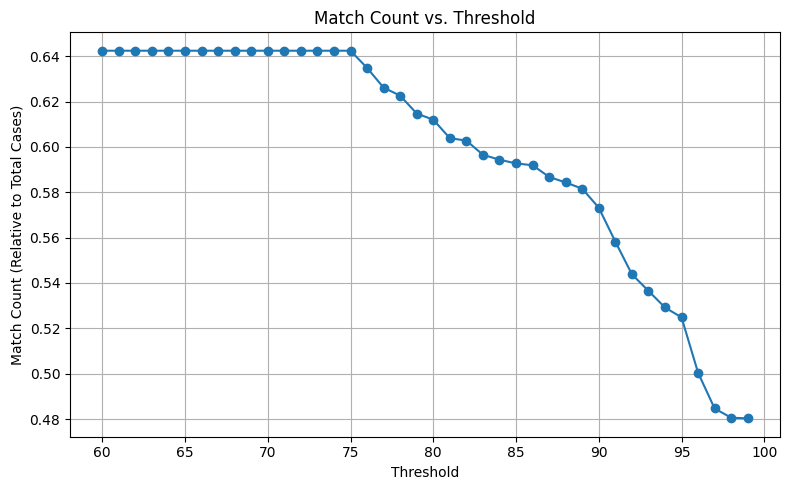

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(results_df['threshold'], results_df['match_count_relative'], marker='o')
plt.xlabel('Threshold')
plt.ylabel('Match Count (Relative to Total Cases)')
plt.title('Match Count vs. Threshold')
plt.grid(True)
plt.tight_layout()
plt.savefig('../images/plot_match_count_vs_threshold.png', dpi=300)
plt.show()

In [14]:
col_with_made_up_data = pd.Series(["Interferon alpha 2a", "Paclitaxel (nab)", "Filgrastim", "Leuprorelin; Tamoxifen"])

results_atomic = create_substance_service_var(
    col_with_substances=col_with_made_up_data,
    col_with_ref_substances=col_with_ref_substances_ZfKD,
    only_first_match=True
)

results_multiple_hits = create_substance_service_var(
    col_with_substances=col_with_made_up_data,
    col_with_ref_substances=col_with_ref_substances_ZfKD,
    only_first_match=False,
    threshold=0.85,
    max_per_match_id=2
)

In [7]:
results_atomic.head()

,Original,Preprocessed,Hit,Mapped_to,Similarity
0,Interferon alpha 2a,Interferon alpha,Interferon alpha,Interferon alpha-2a,91
1,Paclitaxel (nab),Paclitaxel (nab),Paclitaxel,Paclitaxel,100
2,Filgrastim,Filgrastim,Filgrastim,Filgrastim,100
3,Leuprorelin; Tamoxifen,Leuprorelin; Tamoxifen,Leuprorelin,Leuprorelin,100


In [15]:
results_multiple_hits.head()

,Original,Preprocessed,Hit1,Mapped_to1,Similarity1,Hit2,Mapped_to2,Similarity2
0,Interferon alpha 2a,Interferon alpha,Interferon alpha,Interferon alpha-2a,91,Interferon alpha,Interferon alpha-2b,91
1,Paclitaxel (nab),Paclitaxel (nab),Paclitaxel,Paclitaxel,100,Paclitaxel (nab,Paclitaxel nab,97
2,Filgrastim,Filgrastim,Filgrastim,Filgrastim,100,Filgrastim,Pegfilgrastim,87
3,Leuprorelin; Tamoxifen,Leuprorelin; Tamoxifen,Leuprorelin,Leuprorelin,100,Tamoxifen,Tamoxifen,100


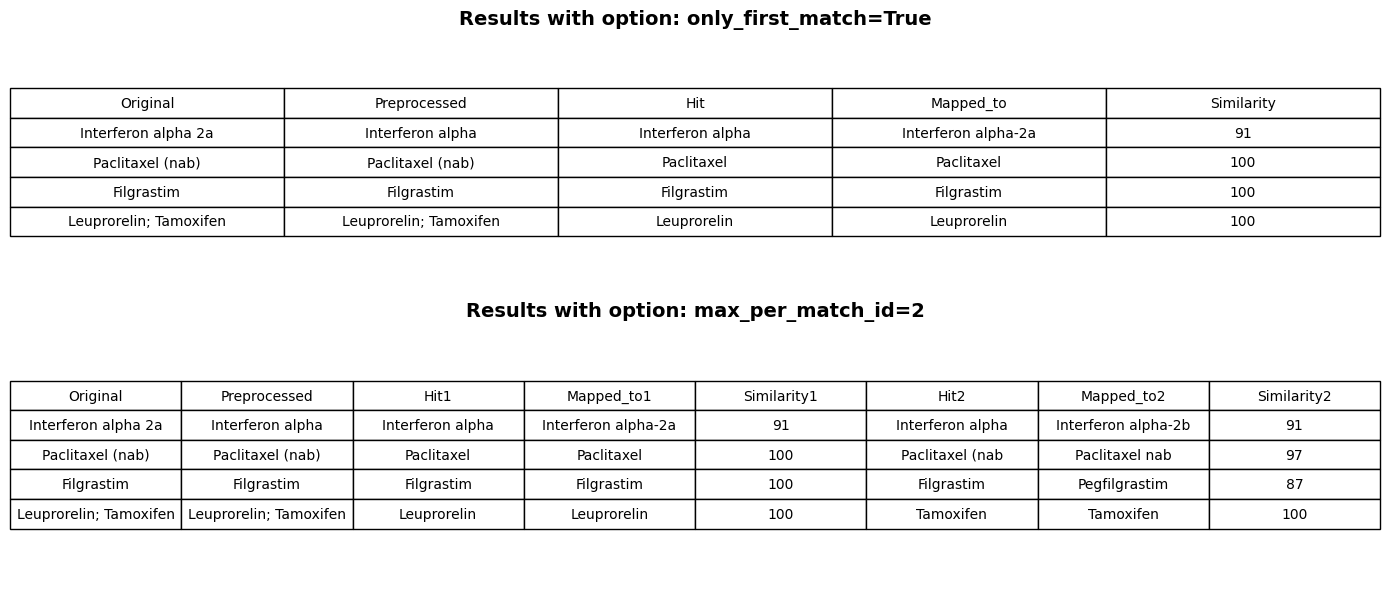

In [22]:
table_data1 = results_atomic.head()
table_data2 = results_multiple_hits.head()

# Set up vertically stacked subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6))  # Adjust height as needed

# Plot first table
ax1.axis('off')
ax1.set_title('Results with option: only_first_match=True', fontsize=14, fontweight='bold', pad=10)
table1 = ax1.table(cellText=table_data1.values,
                   colLabels=table_data1.columns,
                   cellLoc='center',
                   loc='center')
table1.auto_set_font_size(False)
table1.set_fontsize(10)
table1.scale(1, 1.5)

# Plot second table
ax2.axis('off')
ax2.set_title('Results with option: max_per_match_id=2', fontsize=14, fontweight='bold', pad=10)
table2 = ax2.table(cellText=table_data2.values,
                   colLabels=table_data2.columns,
                   cellLoc='center',
                   loc='center')
table2.auto_set_font_size(False)
table2.set_fontsize(10)
table2.scale(1, 1.5)

# Save the figure
plt.tight_layout()
plt.savefig('../images/atomic_vs_multiple.png', dpi=300, bbox_inches='tight')
plt.show()